In [6]:
import brian2 as br
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy
import scipy as sp
from scipy import optimize as op
import seaborn as sns

import dh_parameters as dp
import dh_model as dh

%matplotlib notebook
reload(dp);
reload(dh);

In [2]:
nts = ['pr_noci','e_nts','i_gal']
ats = ['pep2','AB_ltmr']
Ns = dp.get_Ns()
intrinsics_df = dp.intrinsics_table_w_units()
ng_output_dfs = dp.interneuronal_connectivity_tables()
ag_output_dfs = dp.afferent_connectivity_tables()

In [158]:
ndf = {}
adf ={}
for param,df in ng_output_dfs.items():
    ndf[param] = ng_output_dfs[param].loc[['pr_noci','e_nts','i_gal'],['pr_noci','e_nts','i_gal']]

for param,df in ag_output_dfs.items():
    adf[param] = ag_output_dfs[param].loc[['pep2'],['pr_noci','e_nts','i_gal']]    
    
for param,df in ndf.items():
    ndf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    ndf[param].index = ['pr_noci', 'e_nts', 'i_WDR']
    
for param,df in adf.items():
    adf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    
ndf['p'].loc['i_WDR'] = [0.7,0.75,0.8]
ndf['w_mu'].loc['i_WDR'] = [1.e-9,1.1e-9,1.2e-9]
ndf['w_sigma'].loc['i_WDR'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['i_WDR']=['i','i','i']

ndf['p'].loc['e_nts'] = [0.5,0.9,0.8]
ndf['w_mu'].loc['e_nts'] = [0.5e-9,0.6e-9,1e-9]
ndf['w_sigma'].loc['e_nts'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['e_nts']=['e','e','e']

adf['p'].loc['pep2'] = [1,0.,0.8]
adf['w_mu'].loc['pep2'] = [2e-9,1e-9,1.5e-9]
adf['w_sigma'].loc['pep2'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['pep2']=['e','e','e']

adf['p'].loc['AB_ltmr'] = [0,0.9,0.8]
adf['w_mu'].loc['AB_ltmr'] = [1e-9,1e-9,1.5e-9]
adf['w_sigma'].loc['AB_ltmr'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['AB_ltmr']=['e','e','e']


nts = ['pr_noci', 'e_nts', 'i_WDR']
Ns['pr_noci'] = 10
Ns['e_nts'] = 10
Ns['i_WDR'] = 5
Ns['pep2'] = 10
Ns['AB_ltmr'] = 10

intrinsics_df.loc['i_WDR'] = intrinsics_df.loc['i_gal']

for nt in nts:
    intrinsics_df.loc[nt,'tau_r'] = 0.2 
    intrinsics_df.loc[nt,'V_r'] = -70 
    intrinsics_df.loc[nt,'tau_u'] = 100
    
intrinsics_df.loc['i_WDR','b'] = 0

In [179]:
#compact intrinsics
idf = intrinsics_df.T.reset_index().melt(id_vars = ['units','index'])
idf.rename(columns = {'index':'param','variable':'ng'},inplace = True)
idf;

,units,param,ng,value
0,mV,E_l,pr_noci,-60
1,mV,E_e,pr_noci,0
2,mV,E_i,pr_noci,-70
3,pF,C_m,pr_noci,40
4,mV,V_th,pr_noci,-40
5,mV,V_r,pr_noci,-70
6,ms,tau_e,pr_noci,2
7,ms,tau_i,pr_noci,5
8,ms,tau_r,pr_noci,0.2
9,nS,g_l_mu,pr_noci,2


In [157]:
adf['p']

,level_0,index,pr_noci,e_nts,i_WDR,p
0,0,pep2,1.0,0.0,0.8,p
1,1,AB_ltmr,0.0,0.9,0.8,p


In [182]:
#compact connectivity
cdf_list = []
for key in adf.keys():
    tempdf = adf[key].copy()
    _pre = list(tempdf.index)
    _post = list(tempdf.columns)
    pres = []
    posts = []
    vals = []
    for pre in _pre:
        for post in _post:
            pres.append(pre)
            posts.append(post)
            vals.append(tempdf.loc[pre,post])

    new_df = pd.DataFrame({'pre':pres,'post':posts,'value':vals})
    new_df['param'] = key
    cdf_list.append(new_df)
    
for key in ndf.keys():
    tempdf = ndf[key].copy()
    _pre = list(tempdf.index)
    _post = list(tempdf.columns)
    pres = []
    posts = []
    vals = []
    for pre in _pre:
        for post in _post:
            pres.append(pre)
            posts.append(post)
            vals.append(tempdf.loc[pre,post])

    new_df = pd.DataFrame({'pre':pres,'post':posts,'value':vals})
    new_df['param'] = key
    cdf_list.append(new_df)

cdf = pd.concat(cdf_list)
cdf

,pre,post,values,param
0,pep2,pr_noci,1,p
1,pep2,e_nts,0,p
2,pep2,i_WDR,0.8,p
3,AB_ltmr,pr_noci,0,p
4,AB_ltmr,e_nts,0.9,p
5,AB_ltmr,i_WDR,0.8,p
0,pep2,pr_noci,2e-09,w_mu
1,pep2,e_nts,1e-09,w_mu
2,pep2,i_WDR,1.5e-09,w_mu
3,AB_ltmr,pr_noci,1e-09,w_mu


In [175]:
pd.wide_to_long(tempdf)

TypeError: wide_to_long() missing 3 required positional arguments: 'stubnames', 'i', and 'j'

In [143]:
reload(dh)

ds = dh.sim()
ds['dt'] = sim_dt = 0.1*br.ms
ds['nts'] = nts
ds['ats'] = ats
ds['adf'] = adf
ds['ndf'] = ndf
ds['intrinsics_df'] = intrinsics_df.loc[nts + ['units'],:]
ds['Ns'] = Ns

ds.initialize_sim_objects()
wdf,wmat = ds.get_weight_matrix()

In [147]:
#output = tensor: rates x psth x num_trials
num_trials = 6
block_length = 3
conditions = 2
num_repeats = 1
duration = 25 * br.ms
trial_durations = [duration] * num_trials
ds.initialize_inputs(trial_durations)

In [148]:
psth_kernel,_ = dh.gaussian_psth(duration, ds['dt'], mu = 12.5 * br.ms, sigma = 3 * br.ms)

rates_of_active_pep2 = np.ones((num_trials)) * 10.
rates_of_active_AB_ltmr = np.ones((num_trials)) * 10.


frac_active_pep2 = np.concatenate([np.logspace(-2.2,0,block_length),
                                   np.zeros(block_length)]  * num_repeats)
heat = ([True]*block_length +[False] * block_length)  * num_repeats

frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
                                      np.logspace(-2.2,0,block_length)]  * num_repeats )
mech = ([False]*block_length +[True] * block_length)  * num_repeats

at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices


at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech

ds.initialize_target_outputs()
ds.finalize_inputs()

# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     ds['inputs'][trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

<IPython.core.display.Javascript object>


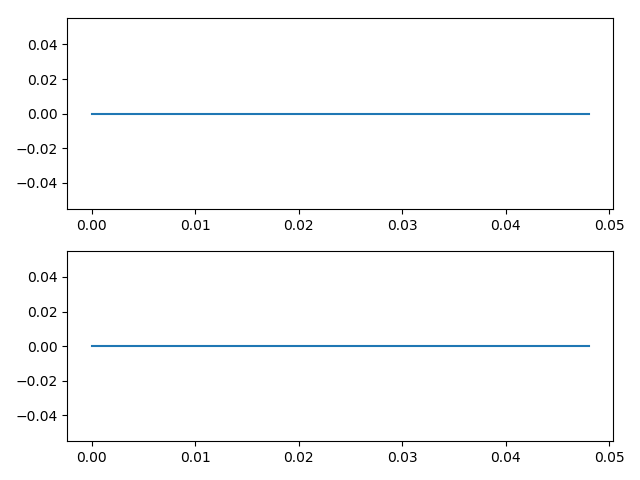

In [146]:
ds.plot_ag_psths();

In [23]:
def stack_I_ex_arrays(I_ex_arrays):
    return np.concatenate(list(I_ex_arrays.values()),axis = 1)

In [25]:
net.restore()

In [141]:
cost, observed_spikes = dh.run_sim(ds, dh.mean_spike_count_cost_func)

In [142]:
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    df[nt+'_mean_rate'] = this_rates

spikes_df = dh.spikes_to_df(sim_objects)

NameError: name 'sim_objects' is not defined

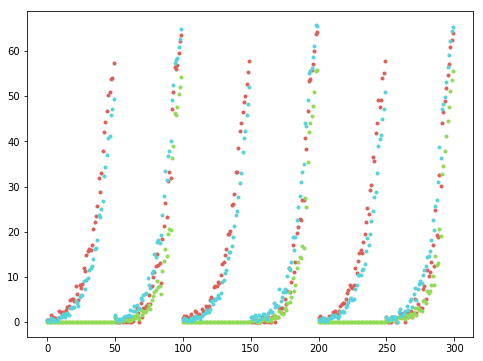

In [14]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)
y_bias = 0
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    ax.plot(this_rates,'.',color=cmap[j])

In [18]:
%matplotlib inline

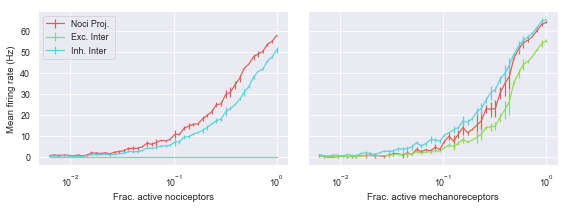

In [16]:
sns.set_style('darkgrid')
sns.set_context('paper')
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,2,figsize = (8,3), sharex = True,sharey = True)
ax = ax.flatten()


heat_ctrl = df['heat'] 
mech_ctrl = df['mech'] 

inds = [heat_ctrl,mech_ctrl]
ivs = ['frac_active_pep2','frac_active_AB_ltmr']

for i, (ind,iv) in enumerate(zip(inds,ivs)):
    this_df = df[ind]
    agg_df = this_df.groupby(iv).agg(['mean','std']).reset_index()
    ax[i].errorbar(agg_df[iv],agg_df['pr_noci_mean_rate']['mean'],
                   agg_df['pr_noci_mean_rate']['std'],color = cmap[0],
                   linestyle = '-',marker = 'None')
    ax[i].errorbar(agg_df[iv],agg_df['e_nts_mean_rate']['mean'],
                   agg_df['e_nts_mean_rate']['std'],color = cmap[1],
                   linestyle = '-',marker = 'None')
    ax[i].errorbar(agg_df[iv],agg_df['i_WDR_mean_rate']['mean'],
                   agg_df['i_WDR_mean_rate']['std'],color = cmap[2],
                   linestyle = '-',marker = 'None')
    ax[i].set_xscale('log')
ax[0].legend(['Noci Proj. ','Exc. Inter','Inh. Inter'])
ax[0].set_xlabel('Frac. active nociceptors')
ax[1].set_xlabel('Frac. active mechanoreceptors')
ax[0].set_ylabel('Mean firing rate (Hz)')
plt.tight_layout()

f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/stronger_E_to_pr_IO.png',dpi = 300)

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(sim_objects['spike_mons'].items()):
    ax.plot(spike_mon.t/br.ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 0.1);
    y_bias += ngs[ct].N
    
ax.plot(ag_inputs_full_trial['pep2']['spike_times']/br.ms,
        ag_inputs_full_trial['pep2']['indices']+y_bias,'.',color='k',alpha = 0.1)
ax.plot(ag_inputs_full_trial['AB_ltmr']['spike_times']/br.ms,
        ag_inputs_full_trial['AB_ltmr']['indices']+y_bias,'.',color='y',alpha = 0.1)
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))
# ax.set_xlim((0,1000))

In [22]:
spikes_df['trial_t']  = spikes_df['t'] - spikes_df['trial_start']

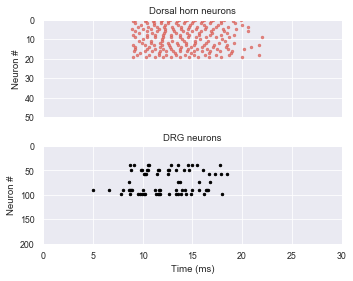

In [23]:
trial = 23

cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(2,1,figsize = (5,4), sharex = True)
ax = ax.flatten()

y_bias = 0
for j,nt in enumerate(['pr_noci','e_nts','i_WDR']):
    ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
    ax[0].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = cmap[j],alpha = 0.7)
    y_bias += sim_objects['neuron_groups'][nt].N
    
ax[0].set_ylim((50,0))
ax[0].set_ylabel('Neuron #')
ax[0].set_title('Dorsal horn neurons')
ax[0].set_xlim((0,30))


y_bias = 0 
nt = 'pep2'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'k')

y_bias = 0 
nt = 'AB_ltmr'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'y')
ax[1].set_ylabel('Neuron #')
ax[1].set_title('DRG neurons')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylim((200,0))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/heat_disinhibition_spiking.png',dpi = 300)

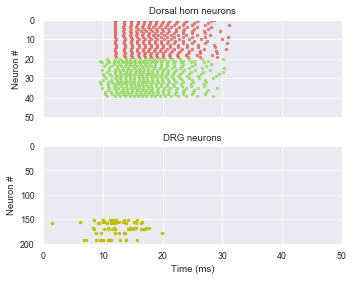

In [26]:
trial = 73

cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(2,1,figsize = (5,4), sharex = True)
ax = ax.flatten()

y_bias = 0
for j,nt in enumerate(['pr_noci','e_nts','i_WDR']):
    ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
    ax[0].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = cmap[j],alpha = 0.7)
    y_bias += sim_objects['neuron_groups'][nt].N
    
# ax[0].set_ylim((ax[0].get_ylim()[-1],ax[0].get_ylim()[0]))
ax[0].set_ylim((50,0))
ax[0].set_ylabel('Neuron #')
ax[0].set_title('Dorsal horn neurons')
ax[0].set_xlim((0,50))

y_bias = 0 
nt = 'pep2'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'k')

y_bias += sim_objects['afferent_groups'][nt].N
nt = 'AB_ltmr'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'y')
ax[1].set_ylabel('Neuron #')
ax[1].set_title('DRG neurons')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylim((200,0))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/mech_disinhibition_spiking.png',dpi = 300)

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (8,6), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,state_mon) in enumerate(states.items()):
    ax[j].plot(state_mon.t/br.ms, state_mon.v[0,:], color = cmap[j]);
#     y_bias += ngs[ct].N
#     ax[j].set_xlim((0,200))
    y_bias+=1
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [33]:
sim_objects.keys()

dict_keys(['network', 'neuron_groups', 'afferent_groups', 'synapses', 'spike_mons', 'states', 'sim_dt', 'inputs', 'target_outputs', 'I_ex_arrays', 'ag_inputs_full'])

In [40]:
br.defaultclock.dt

100. * usecond

In [41]:
reload(dh)

<module 'dh_model' from '/Users/nakaa1/code/py/dh_model/dh_model.py'>

In [42]:
dh.make_all_sim_spikes_pretty(sim_objects)

<IPython.core.display.Javascript object>


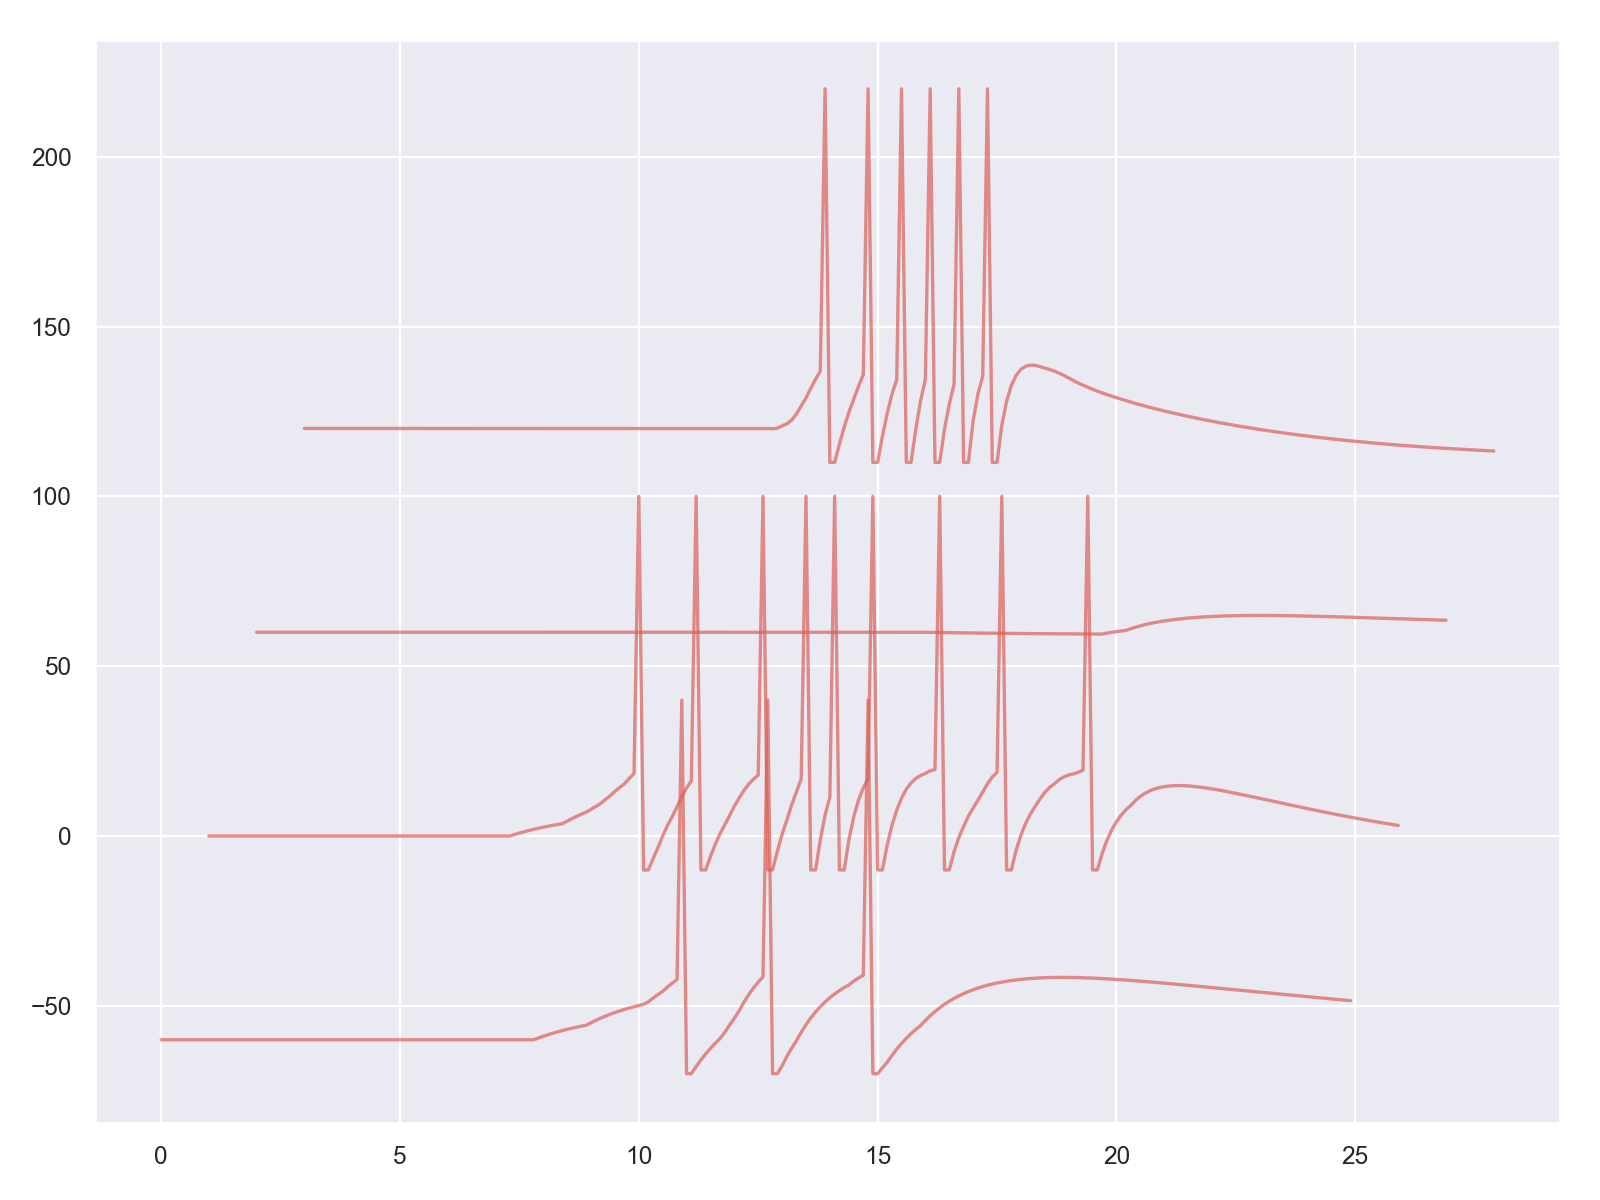

In [43]:
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)


t_dur = inputs[0]['trial_duration']

ct = 'pr_noci'
state_mon = states[ct]
y_bias = 0
x_bias = 0
k=0
for trial in range(0,50,5):
    t_start = trial*t_dur
    t_end = t_start+t_dur
    t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)
    ax.plot((state_mon.t[t_ind]-t_start)/br.ms+x_bias, state_mon.v[k,t_ind]/br.mV+y_bias,
               color = cmap[0],alpha = 0.7);
    y_bias += 60
    x_bias += 1
plt.tight_layout()

<IPython.core.display.Javascript object>


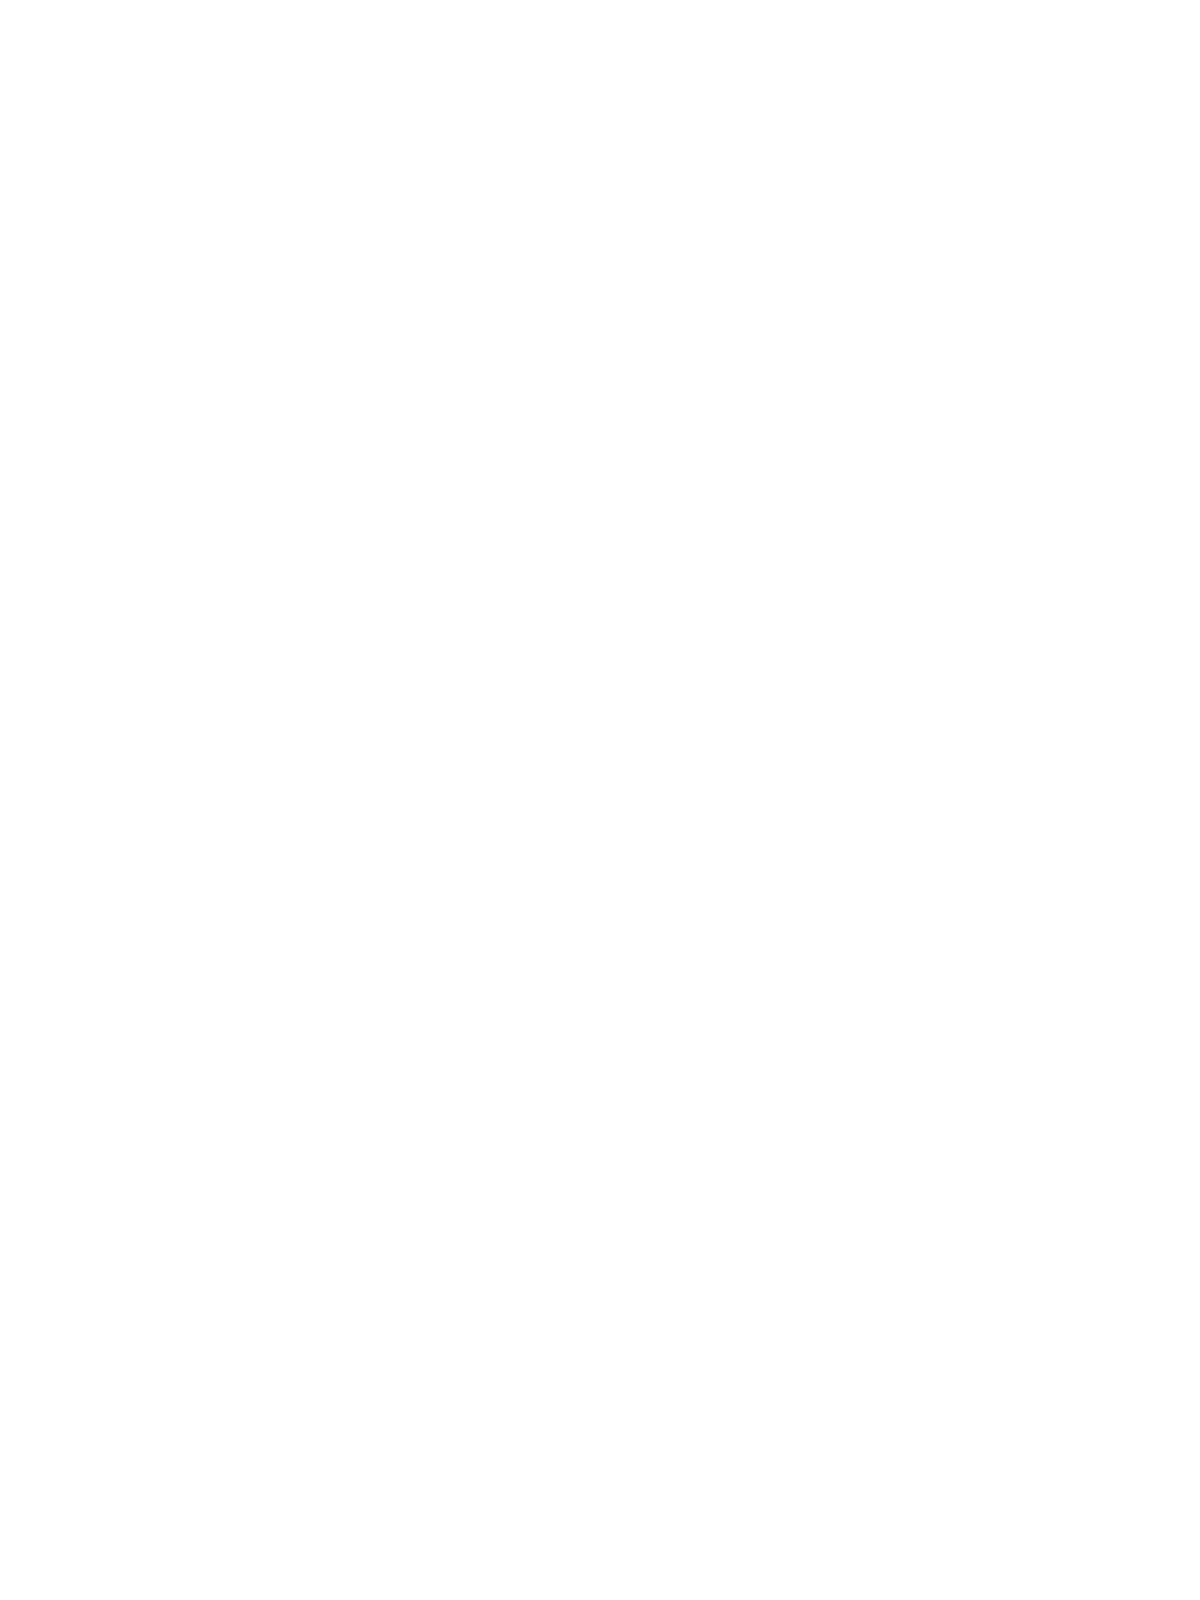

IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
state_mon = states['pr_noci']
sns.set_style('darkgrid')
f,ax = plt.subplots(4,1,figsize = (6,8), sharex = True)
ax = ax.flatten()
trial = 30
t_dur = inputs[0]['trial_duration']
t_start = trial*t_dur
t_end = t_start+t_dur
t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)

labels = ['Nociceptive projection neuron','Excitatory interneuron','Inhibitory interneuron']
for j,(ct,state_mon) in enumerate(states.items()):
    y_bias = 0
    x_bias = 0
    for k in range(1):
        tbase = (state_mon.t[t_ind]-t_start)/br.ms
        trace = state_mon.v[k,t_ind]/br.mV
        ax[j].plot(tbase + x_bias, trace + y_bias,
                   color = cmap[j],alpha = 1);
        y_bias += 20
        x_bias += 1
        ax[j].set_title(labels[j])
        ax[j].set_ylabel('mV')
        
at='pep2'
this_times = ag_inputs_full_trial[at]['spike_times']
this_ind = (this_times>=t_start) & (this_times<t_end)
ax[3].plot((this_times[this_ind]-t_start)/br.ms,
        ag_inputs_full_trial[at]['indices'][this_ind],'.',color='k',alpha = 1)
ax[3].set_title('Nociceptor spiking')
ax[3].set_ylabel('Neuron #')
ax[3].set_xlabel('Time (ms)')
plt.xlim((0,t_dur/br.ms))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/heat_ctrl.png',dpi = 300)

In [ ]:
sns.set_style('darkgrid')
f,ax = plt.subplots(4,1,figsize = (6,8), sharex = True)
ax = ax.flatten()
trial =80
t_dur = inputs[0]['trial_duration']
t_start = trial*t_dur
t_end = t_start+t_dur
t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)

labels = ['Nociceptive projection neuron','Excitatory interneuron','Inhibitory interneuron']
for j,(ct,state_mon) in enumerate(states.items()):
    y_bias = 0
    x_bias = 0
    for k in range(1):
        tbase = (state_mon.t[t_ind]-t_start)/br.ms
        trace = state_mon.v[k,t_ind]/br.mV
        ax[j].plot(tbase + x_bias, trace + y_bias,
                   color = cmap[j],alpha = 1);
        y_bias += 20
        x_bias += 1
        ax[j].set_title(labels[j])
        ax[j].set_ylabel('mV')
        
# ax[3].plot(ag_inputs_full_trial['pep2']['spike_times']/br.ms,
#         ag_inputs_full_trial['pep2']['indices']+y_bias,'.',color='k',alpha = 0.1)
this_times = ag_inputs_full_trial['AB_ltmr']['spike_times']
this_ind = (this_times>=t_start) & (this_times<t_end)
ax[3].plot((this_times[this_ind]-t_start)/br.ms,
        ag_inputs_full_trial['AB_ltmr']['indices'][this_ind],'.',color='y',alpha = 1)
ax[3].set_title('Low-threshold mechanoreceptor spiking')
ax[3].set_ylabel('Neuron #')
ax[3].set_xlabel('Time (ms)')
plt.xlim((0,t_dur/br.ms))
plt.tight_layout()
f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/mech_ctrl.png',dpi = 300)

['i_WDR0',
 'i_WDR1',
 'i_WDR2',
 'i_WDR3',
 'i_WDR4',
 'i_WDR5',
 'i_WDR6',
 'i_WDR7',
 'i_WDR8',
 'i_WDR9']

In [81]:

for conn_name in sim_objects['synapses']:
    print(conn_name)
pre,post = conn_name.split('_to_')
pre

e_nts_to_pr_noci
e_nts_to_e_nts
e_nts_to_i_WDR
i_WDR_to_pr_noci
i_WDR_to_e_nts
i_WDR_to_i_WDR
pep2_to_pr_noci
pep2_to_i_WDR
AB_ltmr_to_e_nts
AB_ltmr_to_i_WDR


'AB_ltmr'

In [ ]:
sim_objects['synapses']['e_nts_to_pr_noci'].w.shape

In [89]:
?nx.draw_networkx

In [98]:
?nx.spectral_layout

<IPython.core.display.Javascript object>


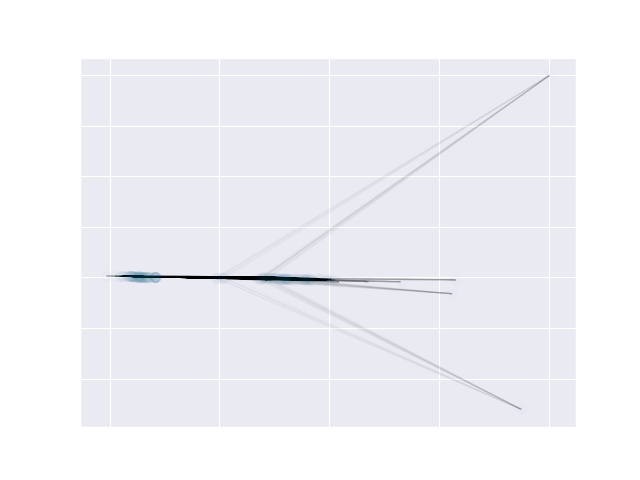

In [83]:
?G.add_edge

<IPython.core.display.Javascript object>


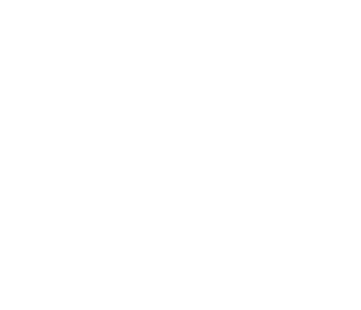

In [63]:
import networkx as nx
G = nx.DiGraph()
G.add_edges_from(
    [('E','I'),('E','P'),('I','P'),('E','E')],weight = 1)

val_map = {'P': cmap[0],
           'E': cmap[1],
           'I': cmap[2],
           }

values = [val_map.get(node, 0.25) for node in G.nodes()]
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
options = {
    'node_color': values,
    'node_size': 1500,
    'edge_color': edge_colors,
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'arrows':True}
nx.draw_networkx_labels(G, pos)
nx.draw(G,pos, **options)

# pylab.show()
# nx.draw_networkx(G[, pos, arrows, with_labels])

# }
# nx.draw_networkx(G, arrows=True, **options)

# nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)
plt.show()

In [ ]:
#output = tensor: rates x psth x num_trials
num_trials = 600
block_length = 50
conditions = 4
num_repeats = 1
trial_durations = [duration] * num_trials
inputs = dh.initialize_inputs(ags,ngs,num_trials,trial_durations = trial_durations)
psth_kernel,_ = dh.gaussian_psth(duration, sim_dt, mu = 12.5 * br.ms, sigma = 3 * br.ms)

rates_of_active_pep2 = np.ones((num_trials)) * 10.
rates_of_active_AB_ltmr = np.ones((num_trials)) * 10.


frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
                                   np.zeros(block_length)] * 2 * num_repeats)
# frac_active_pep2 = np.concatenate([np.linspace(0.001,1,block_length),
#                                    np.zeros(block_length)] * 2 * num_repeats)
heat = ([True]*block_length +[False] * block_length) * 2 * num_repeats

frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
                                      np.logspace(-3,0,block_length)] * 2 * num_repeats )
# frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
#                                       np.linspace(0.001,1,block_length)] * 2 * num_repeats )
mech = ([False]*block_length +[True] * block_length) * 2 * num_repeats

# frac_active_pep2 = np.random.rand(num_trials)
# frac_active_AB_ltmr = np.random.rand(num_trials)

# frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
#                                    np.zeros(block_length),
#                                    np.random.rand(block_length*2)*0.5] * num_repeats )
# heat = ([True]*block_length +[False] * block_length +[False] * block_length*2)  * num_repeats
# frac_active_AB_ltmr = frac_active = np.concatenate([np.zeros(block_length),
#                                                     np.logspace(-3,0,block_length),
#                                                     np.random.rand(block_length*2)*0.5] * num_repeats)
# mech = ([False] * block_length + [True] * block_length + [False] * block_length*2) * num_repeats

at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices


at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech


# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.zeros(block_length*2),np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     inputs[trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

In [ ]:
bins = np.arange(0,net.t/br.ms,10)
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (12,8), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    sns.distplot(spike_mon.t/br.ms, ax = ax[j], bins = bins, color = cmap[j])
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:
update_funcs = {}
# ng_vpl= [('pr_WDR','E_l'),('e_WDR','E_l')]
# update_funcs.update(gen_intrinsics_update_funcs(ngs,ng_vpl))
update_funcs.update(gen_s_w_update_funcs(s))

In [ ]:
global tracker
tracker ={}
tracker['beta'] = []
tracker['observed_spikes'] =[]
tracker['cost']=[]
opts = {}
opts['tracker'] = tracker
opts['track'] = True
opts['verbose'] = True

bounds = [(0,5)] * 6 + [(0,1)] * 3

res = op.differential_evolution(func = dh.fit_network,bounds = bounds,
    args = [update_funcs, sim_objects, inputs, target_outputs, dh.mean_spike_count_cost_func, opts],polish = False,
    maxiter = 30)

In [ ]:
def calc_pop_rates_per_trial(spks,num_trials,duration):
    ng_counts = {}
    ng_counts_avg ={}
    for nt,spikemon in spks.items():
        trial_start = 0 * ms
        spike_trains = spikemon.spike_trains()
        ng_counts[nt] = np.zeros((len(spike_trains.keys()),num_trials))
        ng_counts_avg[nt] = np.zeros((num_trials))
        for trial in range(num_trials):
            trial_end = trial_start + duration
            for n,times in spike_trains.items():
                this_count = sum((times>=trial_start) & (times<trial_end))
                ng_counts[nt][n,trial]= this_count
            ng_counts_avg[nt][trial] = ng_counts[nt][:,trial].mean()
            trial_start += duration
    return ng_counts,ng_counts_avg

def cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR']):
    cost = 0.
    for nt in nts:
        cost += sum((target_ng_rates[nt] - measured_ng_rates[nt])**2) **0.5
    return cost

In [ ]:
st = spike_mons['i_WDR'].spike_trains()[0]
trial_start = 20*ms
trial_end = 50 * ms
st[(st>=trial_start) & (st<trial_end)]

In [ ]:
trialwise_spikes = get_trialwise_spikes(inputs, sim_objects)
trialwise_spikes[0]['i_WDR']

In [ ]:
target_outputs

In [ ]:
inputs[0]['pr_noci']

In [ ]:
def adjust_params_and_rerun(net, ngs, ags, s, beta):
    net.restore()
    
    for name, w_mu in beta.items():
        for syn in s:
            if syn.name == name:
                syn.w = (w_mu + 0.000001 * randn(syn.w.shape[0]))* nS
                syn.w['w < 0 * nS'] = 0 * nS
                
    #resetting
    for trial in range(num_trials):
        for nt,ng in ngs.items():
            ng.reset_variables()
        for at,ag in ags.items():
            this_rate = ag_rates[at][trial]
            psth, time_bins = uniform_psth()
            rates = np.ones((ag.N)) * this_rate
            spikes,ind = generate_population_spikes(psth,rates)
            ag.set_spikes(indices = ind, times = spikes + net.t)
        net.run(duration)


    ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
    measured_ng_rates = {}
    for nt,counts_avg in ng_counts_avg.items():
        measured_ng_rates[nt] = counts_avg / duration*second    
    return measured_ng_rates

def run_network_change_syn(x, net, ngs, ags, s, free_s_params, target_ng_rates):
    beta = {}
    for free_s_param,this_x in zip(free_s_params,x):
        beta[free_s_param] = this_x
    measured_ng_rates = adjust_params_and_rerun(net, ngs, ags, s, beta)
    cost = cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR'])
    
#     beta_.append(x)
#     rates_.append(rates)
#     cost_.append(cost)
    print(x, cost)

    return cost

In [ ]:
bounds = [(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8)]
bounds = [(0.5,8)] * len(free_s_params)
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, ngs,ags,s,free_s_params,target_ng_rates],polish = False,
                                maxiter = 1)

In [ ]:
ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
measured_ng_rates = {}
for nt,counts_avg in ng_counts_avg.items():
    measured_ng_rates[nt] = counts_avg / duration*second    

In [ ]:
cost_func(target_ng_rates,measured_ng_rates)

In [ ]:
ng_counts_avg['pr_noci']

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spks.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:

f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
for z,(nt,counts) in enumerate(ng_counts.items()):
    ax.plot(np.arange(num_trials),counts.mean(axis=0),'-o',color = cmap[z])
        

In [ ]:
counts.mean(axis = 0)

In [ ]:
net.t/duration

In [ ]:
outrate = poprates['pr_noci'].smooth_rate(width = 100 *ms)

In [ ]:
spks['e_grp'].t

In [ ]:
#restoring
hold_spikes = {}
for nt in ngs.keys():
    hold_spikes[nt] = {'ind':[],'spikes':[]}
for trial in range(num_trials):
    net.restore()
    for at,ag in ags.items():
        this_rate = ag_rates[at][trial]
        psth, time_bins = uniform_psth()
        rates = np.ones((ag.N)) * this_rate
        spikes,ind = generate_population_spikes(psth,rates)
        ag.set_spikes(indices = ind, times = spikes)
    net.run(duration, profile = True, report = 'text')
    
    for nt in ngs.keys():
        hold_spikes[nt]['ind'].append(ind.copy())
        hold_spikes[nt]['spikes'].append(spikes.copy())

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [ ]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

In [ ]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [ ]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [ ]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [ ]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

In [ ]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [ ]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


In [ ]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

In [ ]:
bins = np.arange(0,duration/ms,1)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
bins = np.arange(0,duration/ms,1)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
spikes.items()

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)